# VAE Variational Autoencoder

import needest modules

In [1]:
import torch
import torch.nn as nn
from torch import optim 
from torchinfo import summary
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable 

from tqdm import tqdm
import matplotlib.pyplot as plt

from VAE.model import VAE
from VAE.data import Ego4d, DEVICE, BATCH_SIZE, transform1, transform2, ResumableRandomSampler

device cuda is ready


prepare dataset for training

In [2]:
checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/weights/main/VAE_checkpoint_32_50.pt')

/tmp/ipykernel_6423/1850662445.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/wei

In [3]:
print('transform initializate sucsess')
train_dataset = Ego4d(img_dir='/home/qwest/data_for_ml/ROBO',
                           transform1=transform1,
                           transform2=transform2)
print("train_dataset init")
sampler = ResumableRandomSampler(train_dataset)
sampler.set_state(checkpoint['sampler_state'])
print("train_sampler init")
train_loader = DataLoader(dataset=train_dataset,
                           batch_size=32,
                           shuffle=False,
                           sampler=sampler,
                           num_workers=6)
print("train_loader init")

transform initializate sucsess
train_dataset init
train_sampler init
train_loader init


In [4]:
print("Len of trainloader: ",len(train_loader))


Len of trainloader:  419


In [5]:
torch.save(sampler.get_state(), "test_samp.pth")

setup param's for VAE training

In [5]:
lr = 0.001
epochs = 50
latent_dim = 32

create model & optimizer with parametrs ^^^ 

In [6]:
model = VAE(latent_dim, batch_size=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
model.load_state_dict(torch.load('model.pt', weights_only=True))

## OR

In [7]:
checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/weights/main/VAE_checkpoint_32_50.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print("total ep: ", epoch)
print("total loss: ", loss)
print("optimizer: ", optimizer.state)

/tmp/ipykernel_6423/1602026152.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/wei

total ep:  50
total loss:  tensor(0.5642, device='cuda:0', requires_grad=True)
optimizer:  defaultdict(<class 'dict'>, {Parameter containing:
tensor([[[[ 0.1738,  0.2705,  0.5412,  0.5956],
          [ 0.0663,  0.0902,  0.3713,  0.4475],
          [ 0.3139,  0.3334,  0.4364,  0.6084],
          [ 0.5274,  0.2022,  0.5634,  0.6804]],

         [[-0.0640, -0.0106,  0.0953,  0.1348],
          [-0.3434, -0.2590, -0.0674, -0.1338],
          [-0.2620, -0.1370,  0.0781,  0.0235],
          [-0.1626, -0.0396,  0.0053,  0.0167]],

         [[-0.3564, -0.2857, -0.2561, -0.2158],
          [-0.4399, -0.1356, -0.1223, -0.0209],
          [-0.3393, -0.1584,  0.0146,  0.0561],
          [-0.4024, -0.3103, -0.1125, -0.0623]]],


        [[[-0.5304, -0.3821,  0.0444,  0.2818],
          [-0.1355, -0.1068,  0.4391,  0.4456],
          [ 0.0462, -0.0755,  0.3500,  0.4151],
          [ 0.3441,  0.1693,  0.6944,  1.0340]],

         [[-0.9791, -0.7506, -0.4603,  0.2425],
          [-0.6917, -0.1954, -0.

create train func 

In [65]:
def train(epoch):
        """
        train VAE model.

        Args:
        epoch (int): number of epoch.
        """

        x = next(iter(train_loader))
        model.train()
        print(f'Epoch {epoch} start')
        eval_loss = 0
        # Loop through all batches in the training dataset
        for i, data, in enumerate(tqdm(train_loader)):
                data = data.to(DEVICE)
                optimizer.zero_grad()
                
                recon_batch, mu, logvar = model(data)
                loss = model.loss_function(recon_batch, data, mu, logvar)
                eval_loss += loss
                
                loss.backward() # Compute the gradients with respect to the model parameters
                
                optimizer.step() # Update the model parameters using the optimizer

        torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss':loss,
                        'epoch':epoch,
                        'full_model':model,
                        'sampler_state':sampler.get_state(),
                        },
                        f'VAE/weights/main/VAE_checkpoint_{latent_dim}_{epoch}.pt')
        
        print(f"Avg loss: {loss:2f} \n")
        model.eval()
        recon_img, _, _ = model(x[:1].to(DEVICE))
        img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)
        f = plt.imshow(img)
        plt.show()


train model with logging on mlflow 

Epoch 48 start


 88%|████████▊ | 6861/7810 [30:29<04:13,  3.75it/s]


Avg loss: 0.573965 



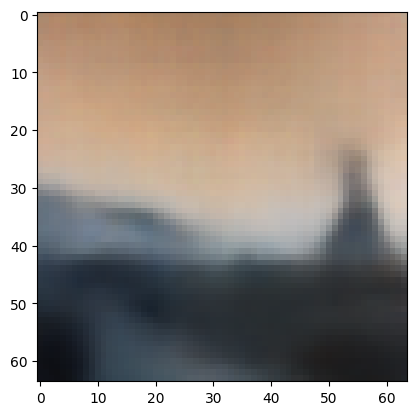

Epoch 49 start


100%|█████████▉| 7797/7810 [34:40<00:03,  3.75it/s]


Avg loss: 0.429606 



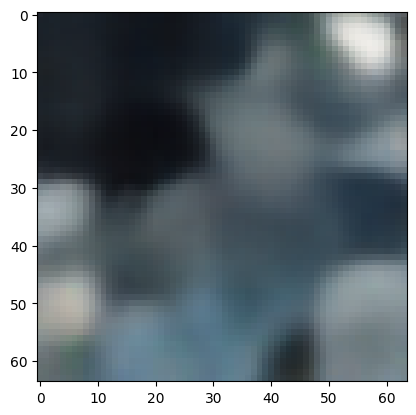

Epoch 50 start


100%|█████████▉| 7797/7810 [34:42<00:03,  3.74it/s]


Avg loss: 0.564248 



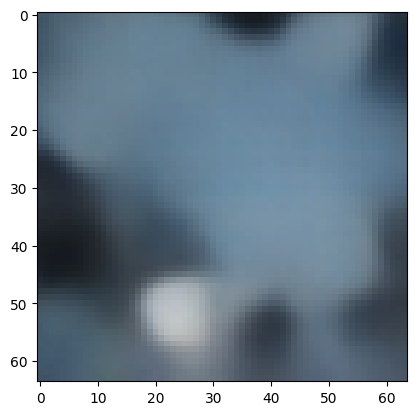

In [66]:
# Log model summary.|
with open("model_summary.txt", "w") as f:
    f.write(str(summary(model)))

for t in range(epoch, epochs+1):
    train(t)

In [11]:
x = next(iter(train_loader))

In [23]:
torch.onnx.export(model, x.to(DEVICE), "model.onnx", input_names=['image'], output_names=['image'])

## Test model

In [8]:
# checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/test_W/VAE_checkpoint_1283.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 512, kernel_size=(4, 4), 

test on exist image 

torch.Size([32, 3, 64, 64])


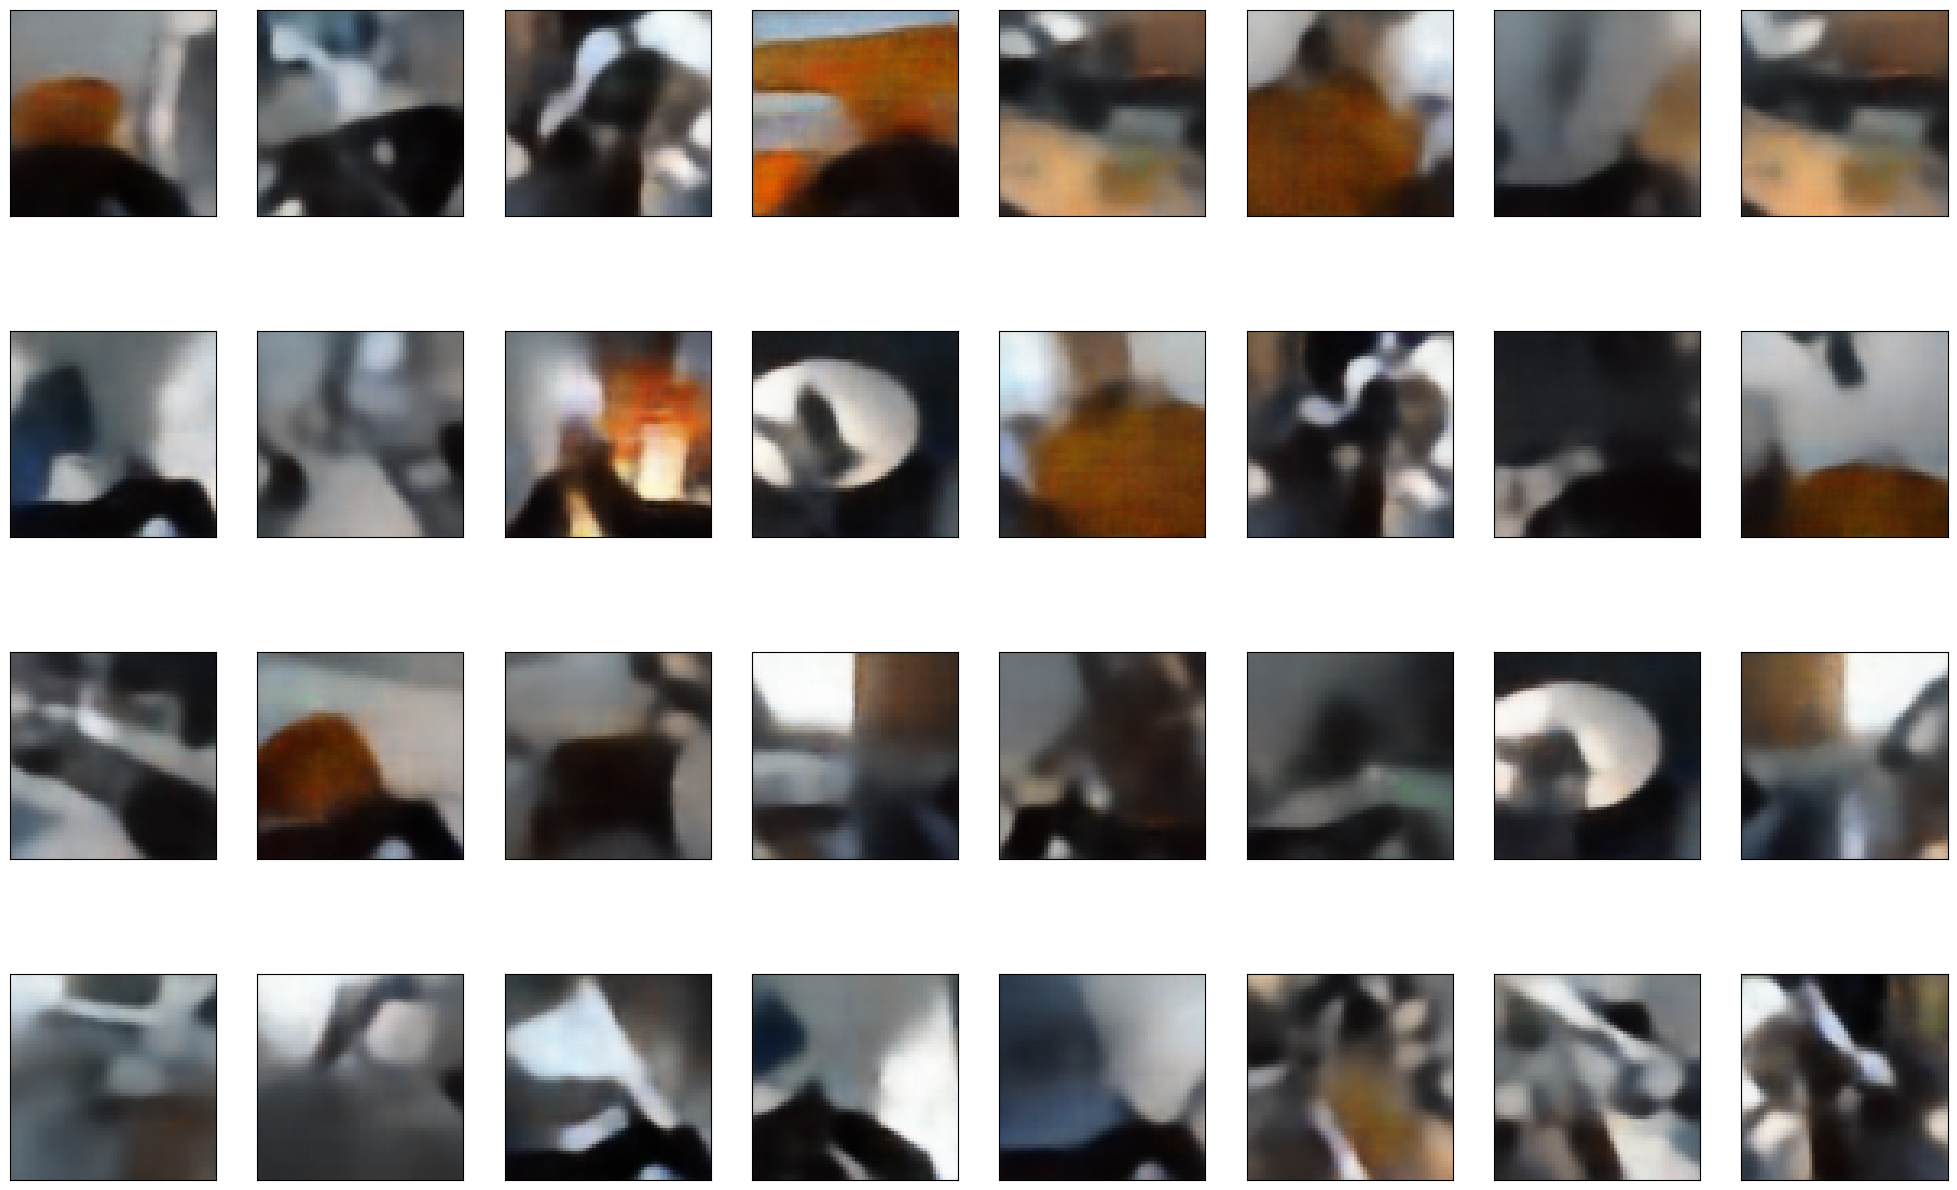

In [9]:
x = next(iter(train_loader))
print(x.size())
reconstructed, mu, _ = model(x.to(DEVICE))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

transition of image to image

In [10]:
x = next(iter(train_loader))

In [13]:
x[0].shape

torch.Size([3, 64, 64])

In [15]:
Z = model.encoder(x.to(DEVICE))

In [34]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0932324..3.0036902].


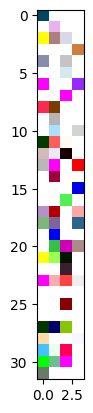

In [39]:
plt.imshow(samples[3].detach().cpu().numpy())

In [33]:
Z[0][8]

tensor([[ 0.1261,  0.3267,  1.3634, -0.6603],
        [-0.7141, -0.1927, -1.2246,  0.8577],
        [ 0.4227,  0.1507, -0.9136,  1.3298],
        [ 0.5279,  0.9200,  0.5638,  0.3060]], device='cuda:0',
       grad_fn=<SelectBackward0>)

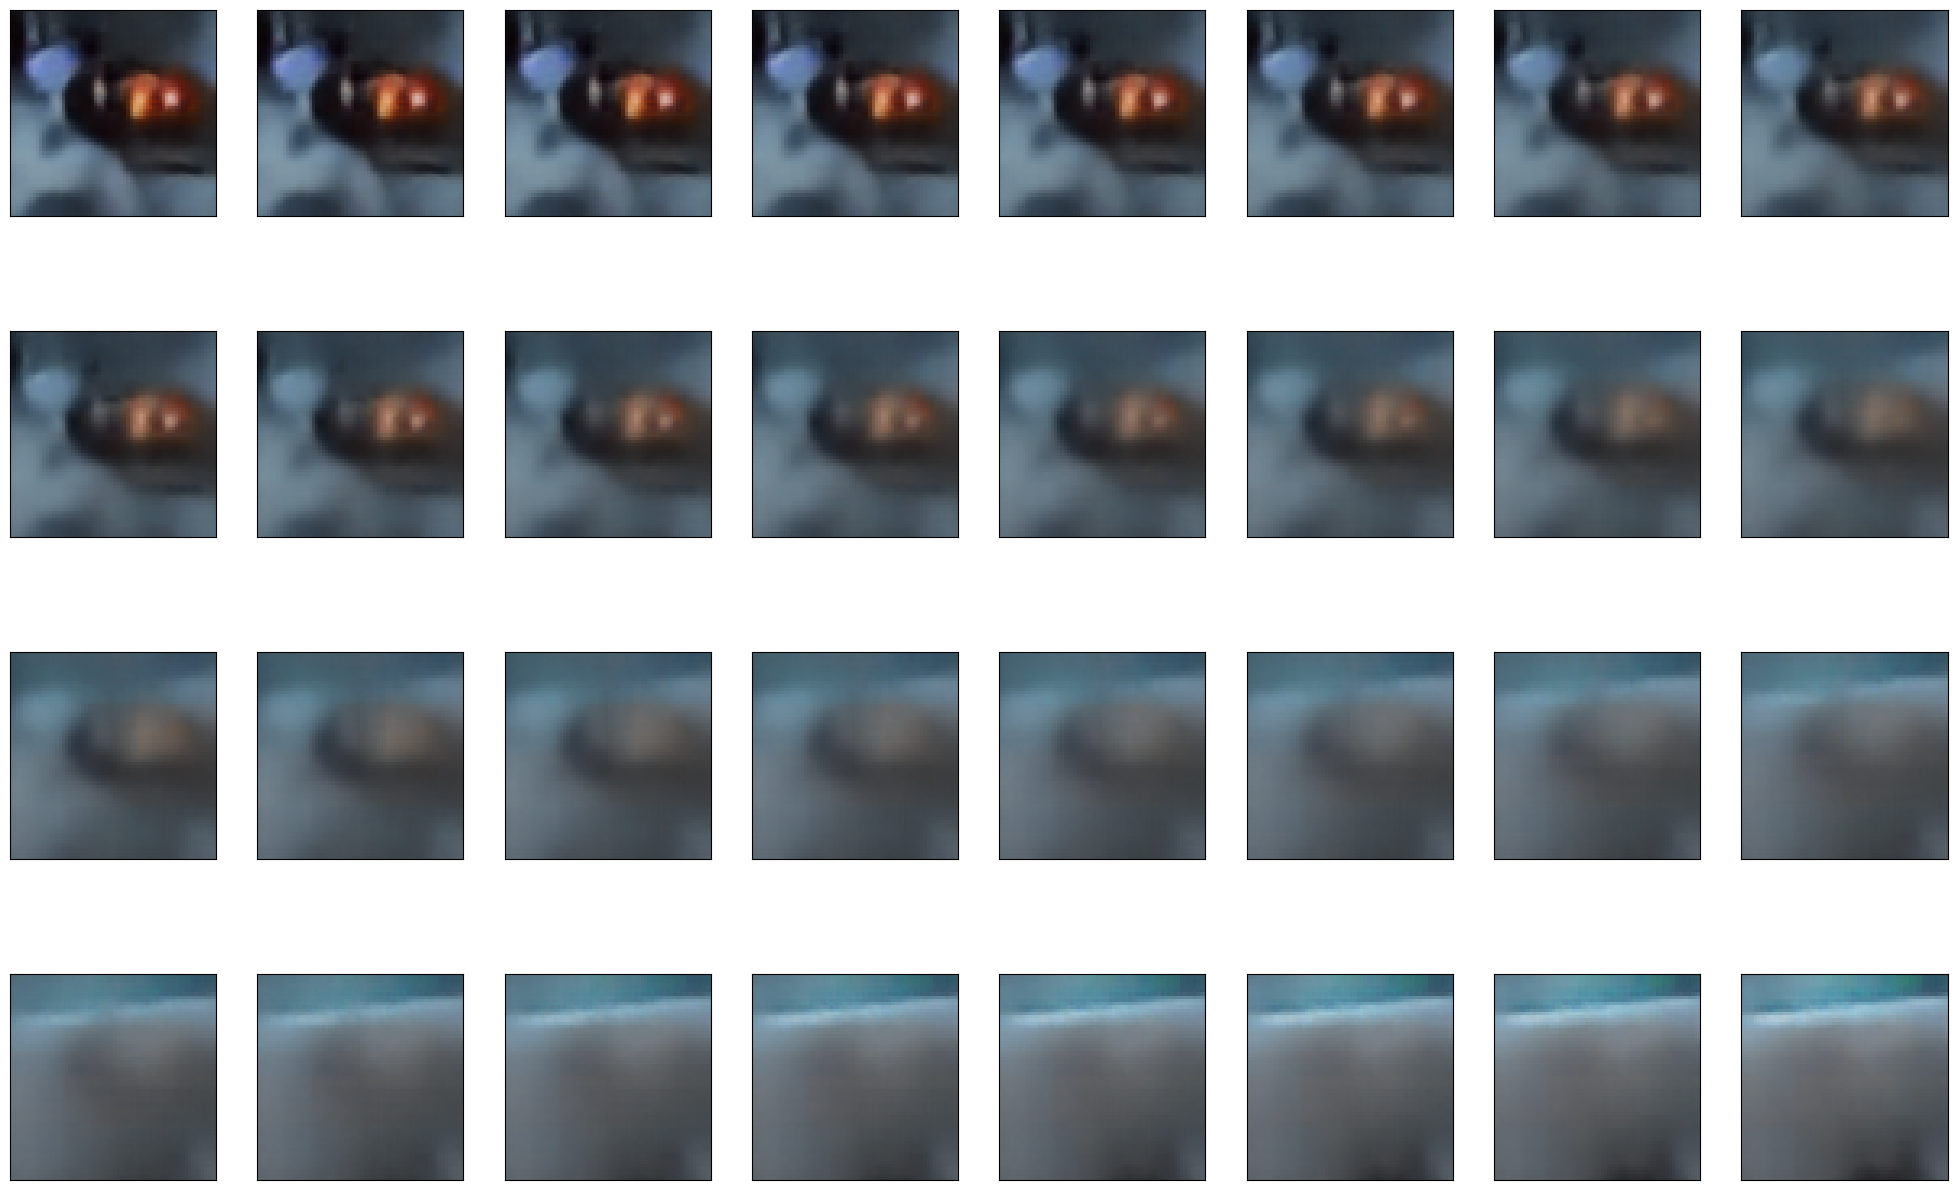

In [69]:
first_dog_idx = 3
second_dog_idx = 8

dz = (mu[second_dog_idx] - mu[first_dog_idx]) / 31
walk = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)
walk[0] = mu[first_dog_idx]

for i in range(1, 32):
    walk[i] = walk[i-1] + dz
walk = model.decoder(walk).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(walk):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

generate image from nose

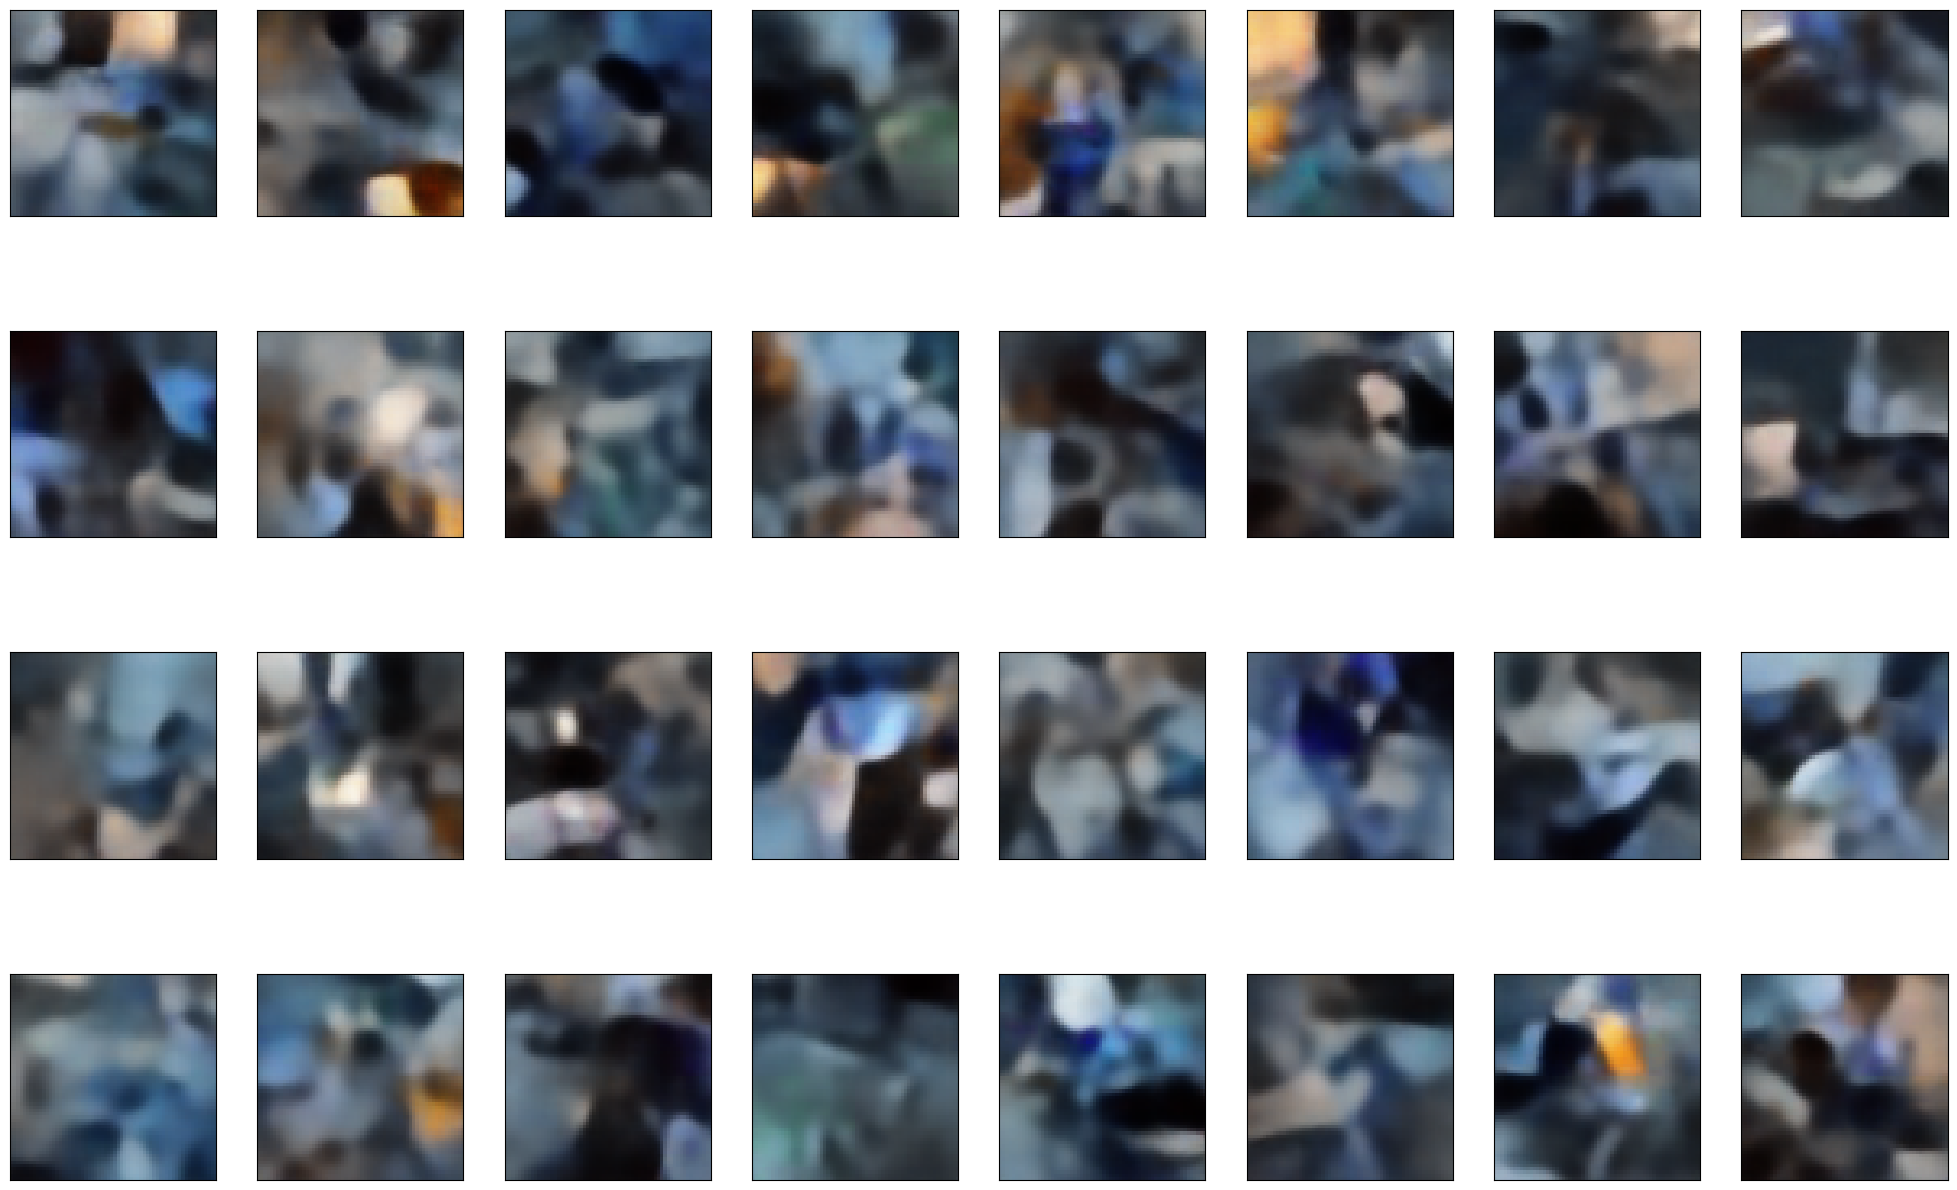

In [70]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(samples):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

In [11]:
torch.save(model.state_dict(), "model.pt")

In [17]:
reconstructed, _, _ = model(x[0][None, :, :, :].to(DEVICE))

In [18]:
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)


In [ ]:
reconstructed[0].shape

In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Создаем исходный массив
array = np.zeros((1, latent_dim, 4, 4))

# Функция для изменения случайных элементов
def update_array(change):
  global array # Важно указать global, чтобы функция могла изменить глобальную переменную
  indices = np.random.choice(np.arange(array.size), size=8, replace=False)
  new_values = np.random.uniform(-5.0, 5.0, size=8)
  array.reshape(-1)[indices] = new_values
  samples = model.decoder(torch.tensor(array).float().to(DEVICE)).detach().cpu().numpy().transpose(0, 2, 3, 1)
  plt.imshow(samples[0])
  #print("Modified array:\n", array)


# Создаем ползунок
slider = widgets.IntSlider(
  min=0,
  max=50, # Максимальное значение - для демонстрации, можно изменить
  step=1,
  description='Update array:',
  continuous_update=False, # Обновление только при отпускании ползунка
  orientation='horizontal',
  layout=widgets.Layout(width='500px')
)

# Связываем ползунок с функцией обновления
slider.observe(update_array, names='value')


# Выводим ползунок и начальный массив
display(slider)
#print("Initial array:\n", array)

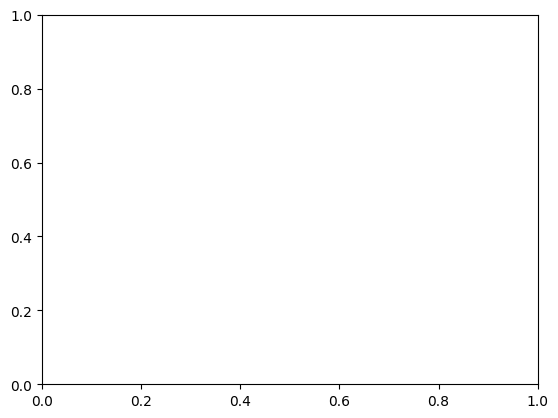

IntSlider(value=0, continuous_update=False, description='Update array:', layout=Layout(width='500px'), max=50)

1
1
1


In [91]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import torch

# Создаем исходный массив # Замените на ваше значение latent_dim
array = np.zeros((1, 32, 4, 4))

# Инициализируем matplotlib для интерактивного режима
plt.ion()
fig, ax = plt.subplots()
img = ax.imshow(np.zeros((64,64,3))) # Инициализируем изображение нулями с тремя каналами
plt.show() # Важно показать график до начала обновления

# Функция для изменения случайных элементов
def update_array(change):
  global array, img
  indices = np.random.choice(np.arange(array.size), size=8, replace=False)
  new_values = np.random.uniform(-5.0, 5.0, size=8)
  array.reshape(-1)[indices] = new_values
  samples = model.decoder(torch.tensor(array).float().to(DEVICE)).detach().cpu().numpy().transpose(0, 2, 3, 1)
  img.set_data(samples[0]) # Обновляем данные изображения
  fig.canvas.draw()     # Перерисовываем изображение
   # Очищаем буфер событий (для гладкости)
  print(1)


# Создаем ползунок
slider = widgets.IntSlider(
  min=0,
  max=50,
  step=1,
  description='Update array:',
  continuous_update=False,
  orientation='horizontal',
  layout=widgets.Layout(width='500px')
)

# Связываем ползунок с функцией обновления
slider.observe(update_array, names='value')

# Выводим ползунок
display(slider)


In [82]:
array

array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]]])

In [72]:
adf = torch.tensor(array).to(DEVICE)

In [73]:
adf.size()

torch.Size([1, 32, 4, 4])

In [74]:
samples = model.decoder(torch.tensor(array).float().to(DEVICE)).detach().cpu().numpy().transpose(0, 2, 3, 1)

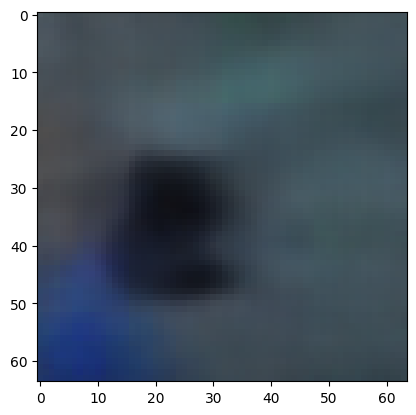

In [75]:
plt.imshow(samples[0])